In [1]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
sys.path.insert(0,"/home/claudio/postdoc/Castle/")
from castle import ASEMLCalculator, AceGlobalRepresentation, AceLocalRepresentation, LPEnsamble, LinearPotential
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils
rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1}

%load_ext autoreload
%autoreload 2

IOStream.flush timed out


In [2]:
species = 'Si'
N = 5
maxdeg = 8
rcut = rcuts[species]
force_name = 'dft_forces'
energy_name = 'DFT_PE'
noise = 1e-6

root = f"/home/claudio/postdoc/data/Zuo/{species}/"

tr_features, val_features = utils.extract_features(root, "train_trajectory.xyz", "validation_trajectory.xyz",
                                                   N=N, maxdeg=maxdeg, rcut=rcut, force_name=force_name,
                                                   energy_name=energy_name, species=species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train_trajectory.xyz", "validation_trajectory.xyz",
    f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz", f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
    force_name = force_name, energy_name =energy_name)

In [3]:
tr_traj = read(root + "train_trajectory.xyz", index = ':')
val_traj = read(root + "validation_trajectory.xyz", index = ':')

CPU times: user 0 ns, sys: 2.4 ms, total: 2.4 ms
Wall time: 408 µs
MAE=0.011 RMSE=0.020 SUP=0.013 R2=0.996
MAE=0.124 RMSE=0.188 SUP=1.038 R2=0.956


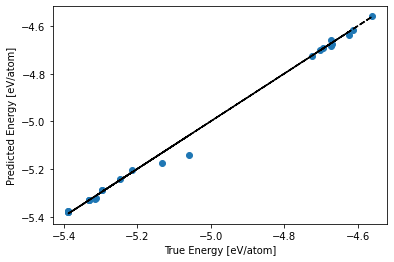

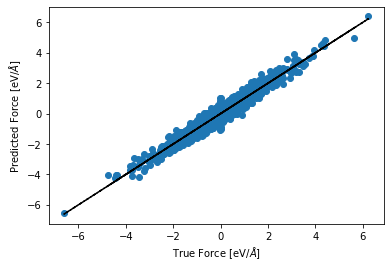

In [4]:
model_lin = LinearPotential()
model_lin.fit_from_features(tr_features, noise, e_t, f_t)

# evaluate its performances
%time ep, fp = model_lin.predict_from_features(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

CPU times: user 12.6 ms, sys: 4.55 ms, total: 17.2 ms
Wall time: 8.6 ms
MAE=0.007 RMSE=0.010 SUP=0.014 R2=0.999
MAE=0.106 RMSE=0.155 SUP=0.817 R2=0.969


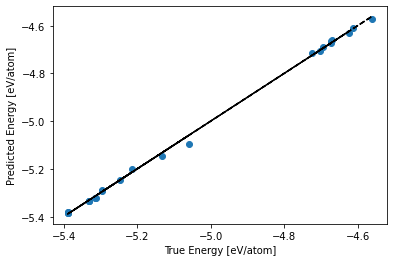

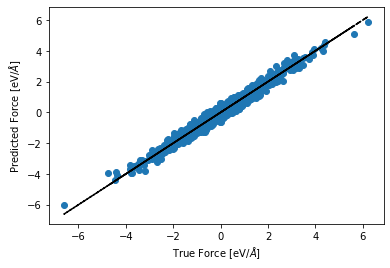

In [32]:
n_clusters = 4
# train the model
model_ens =  LPEnsamble(n_clusters=n_clusters, clustering_type='kmeans', baseline_percentile=0)
model_ens.fit_from_features(tr_features, e_t, f_t, noise)
# evaluate its performances
%time ep, fp = model_ens.predict_from_features(val_features)
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

# EV Curves

In [33]:
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS
from ase.optimize import FIRE
from ase.optimize import MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units
from ase import Atoms

In [34]:
calc_lin = ASEMLCalculator(model_lin)
calc_ens = ASEMLCalculator(model_ens)

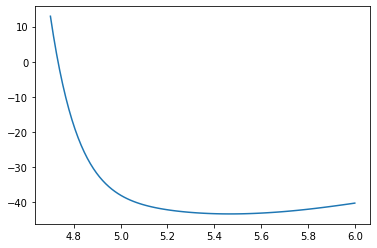

In [35]:
num = 100
en = np.zeros(num)
distances = np.linspace(4.7, 6, num)
for i in range(num):
    atoms = bulk('Si', 'diamond', a=distances[i], cubic=True)
    atoms.set_calculator(calc_lin)
    en[i] = atoms.get_potential_energy()
    
plt.plot(distances, en)
plt.show()

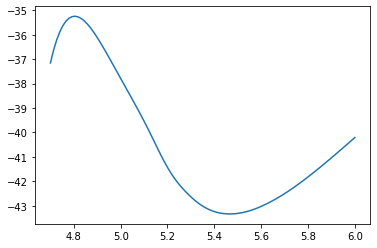

In [36]:
num = 100
en = np.zeros(num)
distances = np.linspace(4.7, 6, num)
for i in range(num):
    atoms = bulk('Si', 'diamond', a=distances[i], cubic=True)
    atoms.set_calculator(calc_ens)
    en[i] = atoms.get_potential_energy()
    
plt.plot(distances, en)
plt.show()

# MD Runs

In [37]:
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_ens)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=5000)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 2 * units.fs)  # 5 fs time step.

def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

# Now run the dynamics
printenergy(atoms)
for i in range(2000):
    dyn.run(100)
    printenergy(atoms)

Energy per atom: Epot = -5.415eV  Ekin = 0.506eV (T=3914K)  Etot = -4.909eV
Energy per atom: Epot = -5.260eV  Ekin = 0.352eV (T=2725K)  Etot = -4.908eV
Energy per atom: Epot = -5.164eV  Ekin = 0.257eV (T=1988K)  Etot = -4.908eV
Energy per atom: Epot = -5.260eV  Ekin = 0.352eV (T=2725K)  Etot = -4.908eV
Energy per atom: Epot = -5.196eV  Ekin = 0.289eV (T=2232K)  Etot = -4.908eV


KeyboardInterrupt: 

In [ ]:
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_lin)
dyn = VelocityVerlet(atoms, 3 * units.fs)  # 5 fs time step.

%time dyn.run(100)

In [ ]:
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_ens)
dyn = VelocityVerlet(atoms, 3 * units.fs)  # 5 fs time step.

%time dyn.run(100)